# Imports

Requirements:
- python 3.6
- numpy
- matplotlib
- seaborn
- pandas
- pytorch
- torchvision
- tqdm
- joblib

Note: some of the images won't show on github, but they should if you download the notebook locally and use a recent enough version of jupyter.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from collections import deque
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")

In [3]:
USE_CUDA = True

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v

In [4]:
!mkdir -p _cache
cache = joblib.Memory(cachedir='_cache', verbose=0)

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='_cache'", use "location=None" instead.
  


In [5]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

In [6]:
def preprocess(inp, p):
    # takes in input of size [parameters x 1]
    inp = inp.data
    n_param = inp.size()[0] 
    dim = inp.size()[1]
    inp2 = w(torch.zeros(n_param, 2*dim))
    keep_grads = torch.abs(inp) >= np.exp(-p)

    inp2[:, 0:dim][keep_grads] = torch.log(torch.abs(inp[keep_grads]) + 1e-8) / p
    inp2[:, dim:][keep_grads] = torch.sign(inp[keep_grads])

    inp2[:, 0:dim][~keep_grads] = -1
    inp2[:, dim:][~keep_grads] = float(np.exp(p)) * inp[~keep_grads]

    return w(Variable(inp2))

# L2LBGDBGD

In [7]:
def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, out_mul, phase='train'):   
    #print(locals())
    if phase == 'train':
        should_train = True
        opt_net.train()
    else:
        should_train = False
        opt_net.eval()
        unroll = 1
    
    # load dataset
    target = target_cls(phase=phase)
    # load optimizee
    optimizee = w(target_to_opt())

    # collect all parameters
    n_params = 0
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))

    # create hidden states for RNN
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]

    
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)

        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss

        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        optimizee_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        
        # for each parameter we disconnect it from the graph and get the gradient 
        # to use as the inputs to the optimizer 
        for name, p in optimizee.all_named_parameters():
            cur_size = int(np.prod(p.size()))

            gradients = detach_var(p.grad.view(cur_size, 1))
            # get updates for the parameters and hidden state of the lstm
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_size] for h in hidden_states],
                [c[offset:offset+cur_size] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_size] = new_hidden[i]
                cell_states2[i][offset:offset+cur_size] = new_cell[i]
            optimizee_params[name] = p + updates.view(*p.size()) * out_mul
            optimizee_params[name].retain_grad()
        
        # after unrolling do the optimizer step
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()

            all_losses = None

            optimizee = w(target_to_opt(**{k: detach_var(v) for k, v in optimizee_params.items()}))
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            optimizee = w(target_to_opt(**optimizee_params))
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever

In [8]:
@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=True, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(RNN_Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, out_mul, phase='train')
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, out_mul, phase='val'))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net

# Policy Gradient - MLP

In [9]:
VARIANCE = w(torch.tensor([0.03]))
N_PREV_GRADS = 5

In [10]:
def do_fit_PG(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, out_mul, phase='train'):
    if phase == 'train':
        should_train = True
        opt_net.train()
    else:
        should_train = False
        opt_net.eval()
        unroll = 1

    # load dataset
    target = target_cls(phase=phase)
    # load optimizee
    optimizee = w(target_to_opt())

    # collect all parameters
    n_params = 0
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))
        
    m = Normal(0.0, VARIANCE)

    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    
    all_losses = []
    saved_log_probs = []
    
    all_gradients = dict()
    for name, p in optimizee.all_named_parameters():
        all_gradients[name] = deque(maxlen=N_PREV_GRADS)
        for _ in range(N_PREV_GRADS):
            all_gradients[name].append(torch.reshape(torch.zeros_like(p), (-1,1)))
    
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)

        all_losses.append(loss)

        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)
                
        optimizee_params = {}

        # for each parameter we disconnect it from the graph and get the gradient
        # to use as the inputs to the optimizer
        for name, p in optimizee.all_named_parameters():
            cur_size = int(np.prod(p.size()))

            gradients = detach_var(p.grad.view(cur_size, 1))
            
            all_gradients[name].append(gradients)
            #print(name, all_gradients[name], all_gradients[name][0].shape, all_gradients[name][-1].shape)
            processed_grads = torch.stack(list(all_gradients[name]), dim=1).squeeze(-1)
                        
            # get updates for the parameters and hidden state of the lstm
            updates = opt_net(
                processed_grads
            )

            if should_train:
                noise = w(m.sample(updates.size()))
                # since the covariance matrix is diagonal, 
                # we can sum up the log probabilities of each dimension
                saved_log_probs.append(m.log_prob(noise).sum()) 

                updates = updates + noise.view(updates.size())
                        
            optimizee_params[name] = p + updates.view(*p.size()) * out_mul
            optimizee_params[name].retain_grad()

        # after unrolling do the optimizer step
        if iteration % unroll == 0:
            if should_train:
                policy_losses = []

                for log_prob, loss in zip(saved_log_probs, all_losses):
                    policy_losses.append(log_prob * loss)
                
                meta_opt.zero_grad()
                policy_losses = torch.stack(policy_losses, dim=0).sum()
                policy_losses.backward()
                
                meta_opt.step()

            all_losses = []
            saved_log_probs = []

            optimizee = w(target_to_opt(
                **{k: detach_var(v) for k, v in optimizee_params.items()}))

        else:
            optimizee = w(target_to_opt(**optimizee_params))
            assert len(list(optimizee.all_named_parameters()))
            
    return all_losses_ever

In [11]:
@cache.cache
def fit_optimizer_PG(target_cls, target_to_opt, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0, **kwargs):
    opt_net = w(PG_Optimizer(**kwargs))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)

    best_net = None
    best_loss = 1e17

    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit_PG(opt_net, meta_opt, target_cls, target_to_opt,
                      unroll, optim_it, out_mul, phase='train')

        loss = (np.mean([
            np.sum(do_fit_PG(opt_net, meta_opt, target_cls, target_to_opt,
                             unroll, optim_it, out_mul, phase='val'))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())

    return best_loss, best_net

## Policy Gradient - Actor Critic

In [12]:
def do_fit_AC(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, out_mul, phase='train'):
    if phase == 'train':
        should_train = True
        opt_net.train()
    else:
        should_train = False
        opt_net.eval()
        unroll = 1

    # load dataset
    target = target_cls(phase=phase)
    # load optimizee
    optimizee = w(target_to_opt())

    # collect all parameters
    n_params = 0
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))
        
    m = Normal(0.0, VARIANCE)

    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    
    all_losses = []
    saved_log_probs = []
    saved_state_values = []
    
    all_gradients = dict()
    for name, p in optimizee.all_named_parameters():
        all_gradients[name] = deque(maxlen=N_PREV_GRADS)
        for _ in range(N_PREV_GRADS):
            all_gradients[name].append(torch.reshape(torch.zeros_like(p), (-1,1)))
    
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)

        all_losses.append(loss)

        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)
                
        optimizee_params = {}

        # for each parameter we disconnect it from the graph and get the gradient
        # to use as the inputs to the optimizer
        for name, p in optimizee.all_named_parameters():
            cur_size = int(np.prod(p.size()))

            gradients = detach_var(p.grad.view(cur_size, 1))
            
            all_gradients[name].append(gradients)
            #print(name, all_gradients[name], all_gradients[name][0].shape, all_gradients[name][-1].shape)
            processed_grads = torch.stack(list(all_gradients[name]), dim=1).squeeze(-1)
                        
            # get updates for the parameters and hidden state of the lstm
            updates, state_value = opt_net(
                processed_grads
            )

            if should_train:
                noise = w(m.sample(updates.size()))

                saved_log_probs.append(m.log_prob(noise)) 
                saved_state_values.append(state_value)
                
                updates = updates + noise.view(updates.size())
                        
            optimizee_params[name] = p + updates.view(*p.size()) * out_mul
            optimizee_params[name].retain_grad()

        # after unrolling do the optimizer step
        if iteration % unroll == 0:
            if should_train:
                policy_losses = []
                value_losses = []
                for log_prob, value, loss in zip(saved_log_probs, saved_state_values, all_losses):
                    loss = w(torch.full_like(value, loss.item()))
                    loss_with_baseline = loss - value
                    policy_losses.append(log_prob * loss_with_baseline)
                    value_losses.append(F.smooth_l1_loss(value, loss))
                
                meta_opt.zero_grad()
                losses = torch.stack(policy_losses, dim=0).sum() + torch.stack(value_losses, dim=0).sum()
                losses.backward()
                
                meta_opt.step()

            all_losses = []
            saved_log_probs = []
            saved_state_values = []

            optimizee = w(target_to_opt(
                **{k: detach_var(v) for k, v in optimizee_params.items()}))

        else:
            optimizee = w(target_to_opt(**optimizee_params))
            assert len(list(optimizee.all_named_parameters()))
            
    return all_losses_ever

In [13]:
@cache.cache
def fit_optimizer_AC(target_cls, target_to_opt, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0, **kwargs):
    opt_net = w(AC_Optimizer(**kwargs))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)

    best_net = None
    best_loss = 1e17

    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit_AC(opt_net, meta_opt, target_cls, target_to_opt,
                      unroll, optim_it, out_mul, phase='train')

        loss = (np.mean([
            np.sum(do_fit_AC(opt_net, meta_opt, target_cls, target_to_opt,
                             unroll, optim_it, out_mul, phase='val'))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())

    return best_loss, best_net

# Experiment repro

## Quadratic functions

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

In [14]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        # Note: assuming the same optimization for theta as for
        # the function to find out itself.
        if theta is None:
#             self.theta = nn.Parameter(torch.randn(10)/10.0 - 0.05)
            self.theta = nn.Parameter(torch.zeros(10))
        else:
            self.theta = theta
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
       

In [15]:
class RNN_Optimizer(nn.Module):
    def __init__(self, preproc=True, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = preprocess(inp, self.preproc_factor)
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)

In [16]:
class PG_Optimizer(nn.Module):
    def __init__(self, preproc=True, hidden_sz=32, n_layers=2, preproc_factor=10.0):
        super().__init__()
        self.n_layers = n_layers
        
        if n_layers == 0:
            if preproc:
                self.linears = nn.ModuleList([nn.Linear(N_PREV_GRADS*2, 1)])
            else:
                self.linears = nn.ModuleList([nn.Linear(N_PREV_GRADS, 1)])
        else:
            if preproc:
                self.linears = nn.ModuleList([nn.Linear(N_PREV_GRADS*2, hidden_sz)])
            else:
                self.linears = nn.ModuleList([nn.Linear(N_PREV_GRADS, hidden_sz)])
            self.linears.extend([nn.Linear(hidden_sz, hidden_sz) for i in range(1, n_layers)])
            self.linears.append(nn.Linear(hidden_sz, 1))
        
        self.preproc = preproc
        self.preproc_factor = preproc_factor

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, inp):
        if self.preproc:
            # Implement preproc described in Appendix A

            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = preprocess(inp, self.preproc_factor)
        y = inp
        for i in range(self.n_layers):
            y = self.linears[i](y)
            y = F.relu(y)
        return self.linears[-1](y)

In [17]:
class AC_Optimizer(nn.Module):
    def __init__(self, preproc=True, hidden_sz=32, n_layers=2, preproc_factor=10.0):
        super().__init__()
        self.n_layers = n_layers
        
        if n_layers == 0:
            if preproc:
                self.action_head = nn.Linear(N_PREV_GRADS*2, 1)
                self.value_head = nn.Linear(N_PREV_GRADS*2, 1)

            else:
                self.action_head = nn.Linear(N_PREV_GRADS, 1)
                self.value_head = nn.Linear(N_PREV_GRADS, 1)
            
        else:
            if preproc:
                self.linears = nn.ModuleList([nn.Linear(N_PREV_GRADS*2, hidden_sz)])
            else:
                self.linears = nn.ModuleList([nn.Linear(N_PREV_GRADS, hidden_sz)])
            self.linears.extend([nn.Linear(hidden_sz, hidden_sz) for i in range(1, n_layers)])
            self.action_head = nn.Linear(hidden_sz, 1)
            self.value_head = nn.Linear(hidden_sz, 1)
        
        self.preproc = preproc
        self.preproc_factor = preproc_factor

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, inp):
        if self.preproc:
            # Implement preproc described in Appendix A

            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = preprocess(inp, self.preproc_factor)
        y = inp
        for i in range(self.n_layers):
            y = self.linears[i](y)
            y = F.relu(y)
        return self.action_head(y), self.value_head(y)

> Each function was optimized for 100 steps and the trained optimizers were unrolled for 20 steps.

I assume this means that each epoch is made up of trying to optimize a
new random function for 100 steps, but we are doing an update of the
optimizer every 20 steps. The number of epochs is thus unspecified, but
according to the graphs it seems to be 100 too.

The experiment below on the various learning rates show that 0.003 is a promising learning rate (it is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer). We train our final model using 0.003.

In [99]:
# for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
#     print('Trying lr:', lr)
#     print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])

loss, rnn_quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100, preproc=True)
print(loss)

KeyboardInterrupt: 

In [ ]:
# for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
#     print('Trying lr:', lr)
#     print(fit_optimizer_LPG(QuadraticLoss, QuadOptimizee, lr=lr)[0])

loss, linear_quad_optimizer = fit_optimizer_PG(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100, hidden_sz=None, n_layers=0, preproc=True)
print(loss)

In [ ]:
# for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
#     print('Trying lr:', lr)

#     opt_net = PG_Optimizer(hidden_sz=32, n_layers=2, preproc=True)
#     print(fit_optimizer_PG(QuadraticLoss, QuadOptimizee, opt_net, lr=lr)[0])

loss, pg_quad_optimizer = fit_optimizer_PG(QuadraticLoss, QuadOptimizee, lr=0.001, n_epochs=100, hidden_sz=32, n_layers=2, preproc=True)
print(loss)

In [ ]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer_AC(QuadraticLoss, QuadOptimizee, lr=lr, hidden_sz=32, n_layers=2, preproc=True)[0])

In [100]:
loss, ac_quad_optimizer = fit_optimizer_AC(QuadraticLoss, QuadOptimizee, lr=0.001, n_epochs=100, hidden_sz=32, n_layers=2, preproc=True)
print(loss)

141001.0
1e+17 141001.0


5505.6
141001.0 5505.6


5019869.0


448190370.0


3127084000.0


6920962600.0


114795160.0


8031435.0


2173251600.0


18127905000.0


78503395000.0


175905730000.0


400468900000.0


668462400000.0


1144376800000.0


1952896600000.0


4638271600000.0


7184860000000.0


11828547000000.0


17420209000000.0


23927185000000.0


30490950000000.0


41196420000000.0


53353170000000.0


63345806000000.0


78725570000000.0


100320930000000.0


116409860000000.0


141932010000000.0


161010670000000.0


194040880000000.0


217656310000000.0


269063200000000.0


274412980000000.0


317838450000000.0


355677150000000.0


412693480000000.0


491495100000000.0


493076540000000.0


599546770000000.0


696577500000000.0


700644460000000.0


775315600000000.0


855680300000000.0


944042330000000.0


1007241400000000.0


1048994760000000.0


1148615500000000.0


1270564100000000.0


1503150100000000.0


1607010000000000.0


1661912400000000.0


KeyboardInterrupt: 

Now we need to find the best learning rate for the various comparison optimizers. We end up finding 0.1 for Adam, 0.03 for RMSprop, 0.01 for SGD and 0.01 for SGD with nesterov momentum (aka NAG).

In [18]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(phase='test')
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)

            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

In [19]:
def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError as e:
            print(e)
            pass
        
        print (loss, lr)
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [20]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

# NB: the momentum parameter for nesterov was found from the following file: https://github.com/torch/optim/blob/master/nag.lua
# since it is mentioned in the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) we use the default values from the optim package in Torch7."
# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))

In [129]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
NUMBER_OF_TEST_RUNS = 200
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((NUMBER_OF_TEST_RUNS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 3))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, 
                                            n_tests=NUMBER_OF_TEST_RUNS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

opt = w(RNN_Optimizer())
opt.load_state_dict(rnn_quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, NUMBER_OF_EPOCHS, out_mul=1.0, phase='test') for _ in range(NUMBER_OF_TEST_RUNS)])

opt = w(PG_Optimizer(hidden_sz=None, n_layers=0, preproc=True))
opt.load_state_dict(linear_quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES) + 1] = np.array([do_fit_PG(opt, None, QuadraticLoss, QuadOptimizee, 
                                                      1, NUMBER_OF_EPOCHS, out_mul=1.0, phase='test') for _ in range(NUMBER_OF_TEST_RUNS)])

opt = w(PG_Optimizer())
opt.load_state_dict(pg_quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES) + 2] = np.array([do_fit_PG(opt, None, QuadraticLoss, QuadOptimizee, 1, NUMBER_OF_EPOCHS, out_mul=1.0, phase='test') for _ in range(NUMBER_OF_TEST_RUNS)])


Finally we plot the learning curve for LSTM vs the different alternatives. For reference, the plot in the paper looks like this:

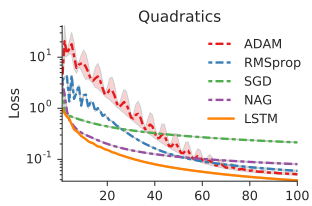

Our result is pretty similar.

/home/benedekf/miniconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


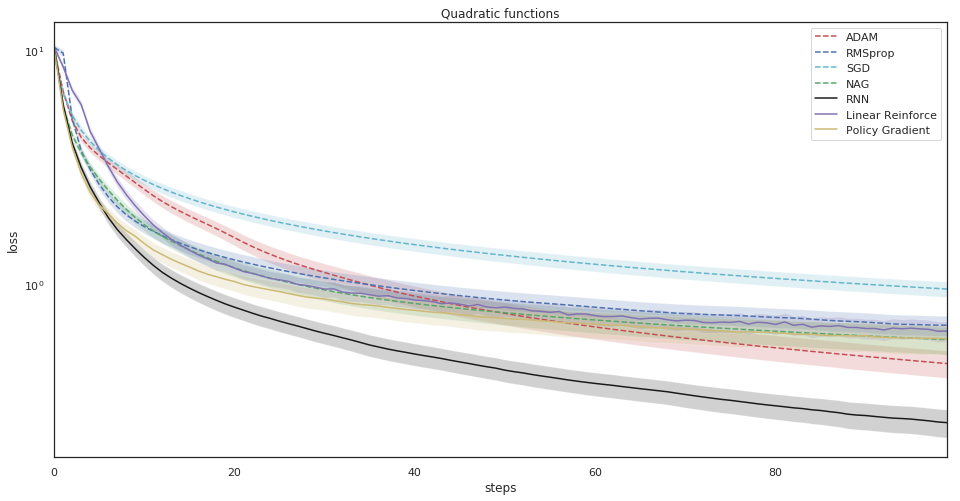

In [130]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Linear Reinforce', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'm', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.lines[-3].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

/home/benedekf/miniconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


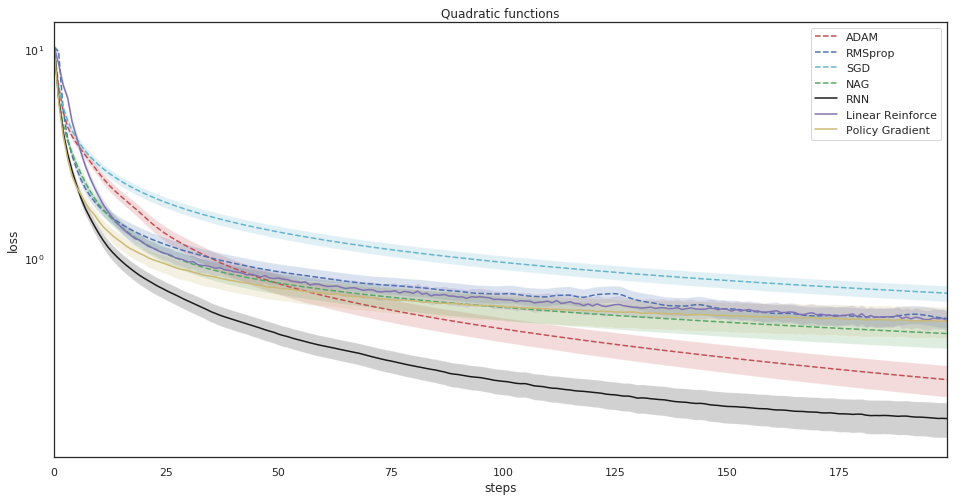

In [131]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Linear Reinforce', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'm', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.lines[-3].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

In [132]:
linear_quad_optimizer

OrderedDict([('linears.0.weight', tensor(1.00000e-02 *
                     [[ 2.4529, -7.8496,  3.3258,  3.4302, -1.2208, -1.3213, -1.0307,
                       -1.2188, -1.5141, -4.0877]])),
             ('linears.0.bias', tensor(1.00000e-03 *
                     [ 2.1593]))])

## MNIST

Now we move on to MNIST. Because all the rest of our code is implemented, we just need to implement the network specified in the paper, namely a single hidden layer, sigmoid, 20 hidden units network. We make it easy to change sigmoid to some other activation, add layers, and change the number of units, because all of these are attempted in the paper.

In [21]:
class MNISTLoss:
    def __init__(self, phase='train'):
        if phase == 'train' or phase == 'val':
            dataset = datasets.MNIST(
                './mnist', train=True, download=True,
                transform=torchvision.transforms.ToTensor()
            )
        elif phase == 'test':
            dataset = datasets.MNIST(
                './mnist', train=False, download=True,
                transform=torchvision.transforms.ToTensor()
            )
        else:
            raise ValueError("Phase can only take values of 'train', 'val' and 'test'. Given: {}".format(phase))
        
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if phase == 'train':
            indices = indices[:len(indices) // 2]
        elif phase == 'val':
            indices = indices[len(indices) // 2:]
        else:
            pass
    
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
        
        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(nn.Module):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()
        # Sadly this network needs to be implemented without using the convenient pytorch
        # abstractions such as nn.Linear, because afaik there is no way to load parameters
        # in those in a way that preserves gradients.
        if kwargs != {}:
            self.params = kwargs
        else:
            inp_size = 28*28
            self.params = {}
            for i in range(n_layers):
                self.params[f'mat_{i}'] = nn.Parameter(torch.randn(inp_size, layer_size) * 0.001) # TODO: use a better initialization
                self.params[f'bias_{i}'] = nn.Parameter(torch.zeros(layer_size))
                inp_size = layer_size

            self.params['final_mat'] = nn.Parameter(torch.randn(inp_size, 10) * 0.001) # TODO:init
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
        
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
                
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        
        cur_layer = 0
        while f'mat_{cur_layer}' in self.params:
            inp = self.activation(torch.matmul(inp, self.params[f'mat_{cur_layer}']) + self.params[f'bias_{cur_layer}'])
            cur_layer += 1
                    
        inp = F.log_softmax(torch.matmul(inp, self.params['final_mat']) + self.params['final_bias'], dim=1)
        l = self.loss(inp, out)
        return l

Like before, we find a promising learning rate (0.01) using a small number of epochs (10) and optimize it fully using more epochs (50).

In [22]:
# for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
#     print('Trying lr:', lr)
#     print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

In [23]:
loss, mnist_rnn_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.01, n_epochs=50, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

45.878815


In [24]:
# for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
#     print('Trying lr:', lr)
#     print(fit_optimizer_PG(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, n_tests=5, n_epochs=10, hidden_sz=32, n_layers=2, preproc=True)[0])

In [25]:
loss, mnist_pg_optimizer = fit_optimizer_PG(MNISTLoss, MNISTNet, lr=0.003, n_epochs=50, n_tests=20, out_mul=0.1, hidden_sz=32, n_layers=2, preproc=True)
print(loss)

68.472855


We find the best learning rates for the competitors...

In [26]:
# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))

And plot! for context, the graph in the original paper looks like this:

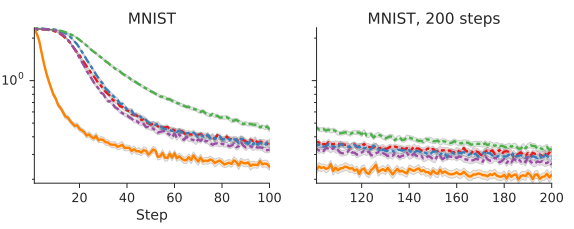

Again we get similar results!!!

In [27]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

In [28]:
@cache.cache
def get_fit_dict_test(fit_func, opt_class, n_tests, opt_dict, *args, **kwargs):
    opt = w(opt_class(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [fit_func(opt, *args, **kwargs) for _ in tqdm(range(n_tests), 'optimizer')]

In [25]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))


fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


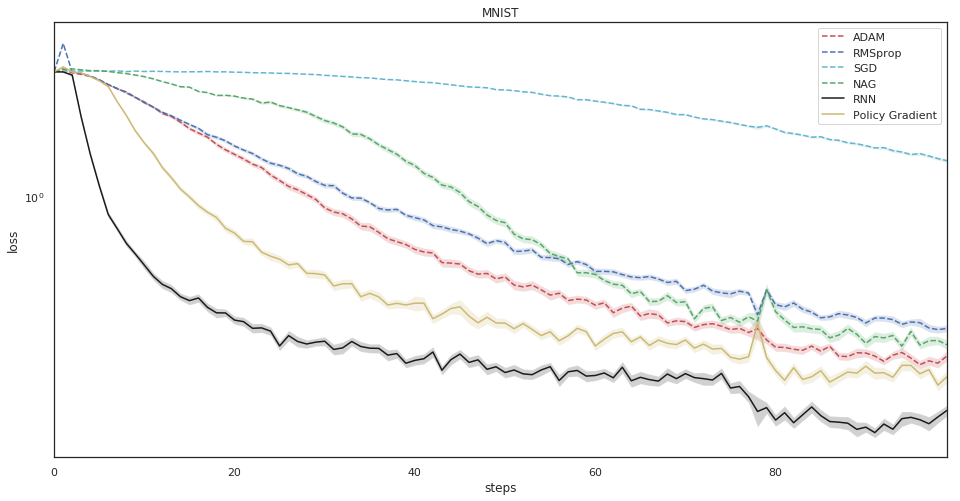

In [26]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


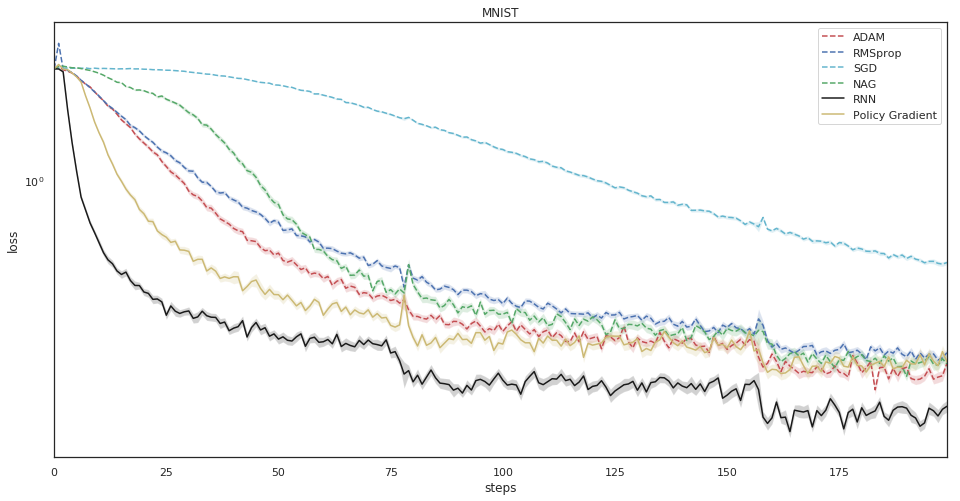

In [27]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [29]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()
        
class MNISTHuge(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=3, layer_size=80, *args, **kwargs)

In [30]:
# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))

# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))

# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))

# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(MNISTLoss, MNISTHuge, opt, **kwargs, n_tests=10))

Same as above, for a 2 layer network. Again LSTM does great even though it was trained on a single layer network, and again we are similar to the paper:

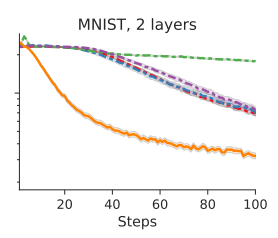

In [30]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTNet2Layer, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTNet2Layer, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


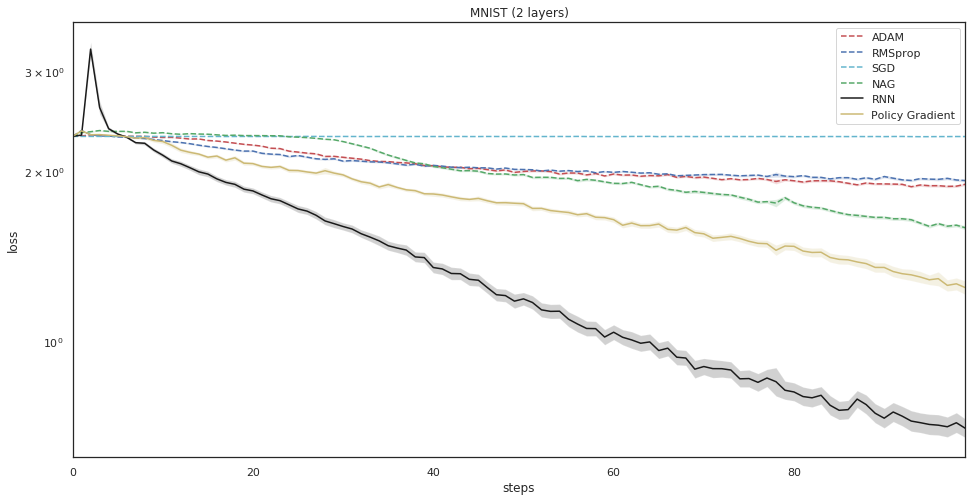

In [31]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


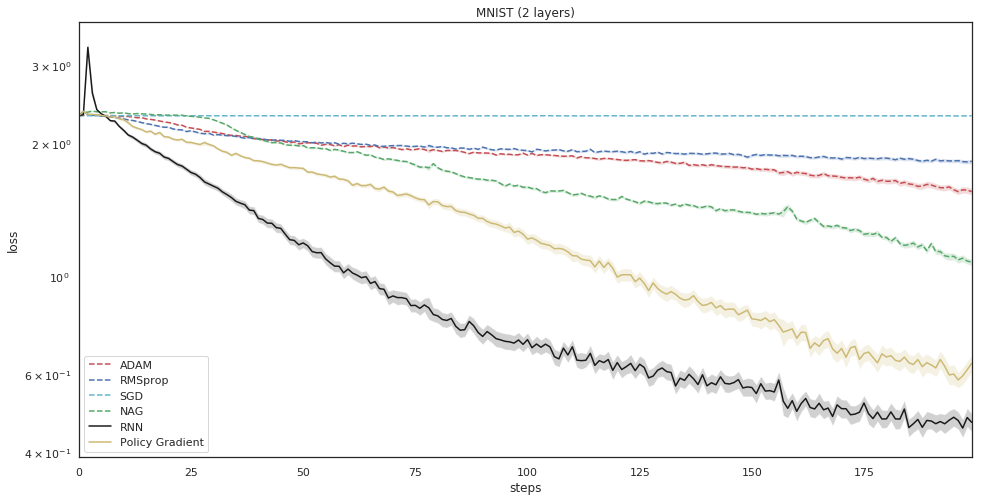

In [32]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

Same as above but for a single layer, 40 hidden unit network.

Paper comparison:
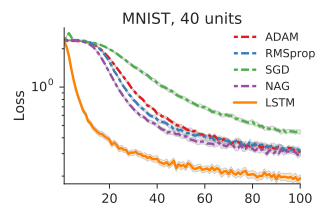

In [33]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTNetBig, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTNetBig, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


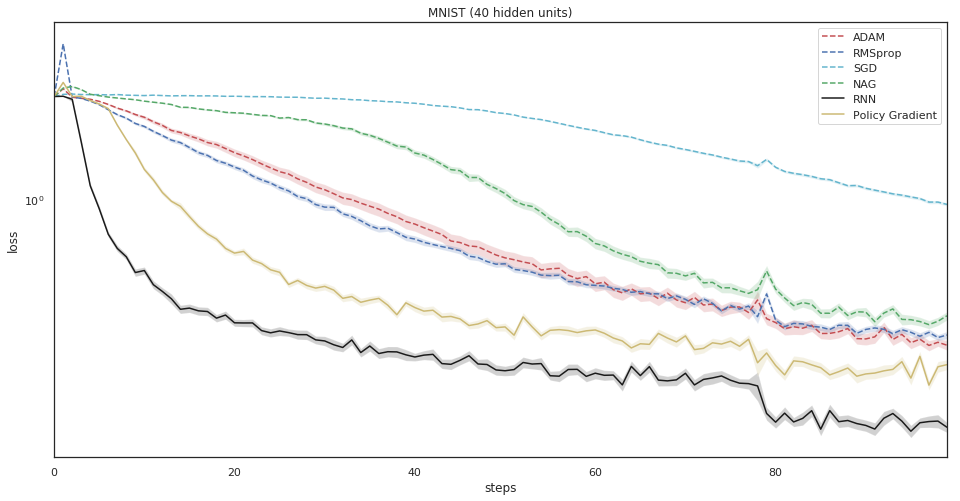

In [34]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


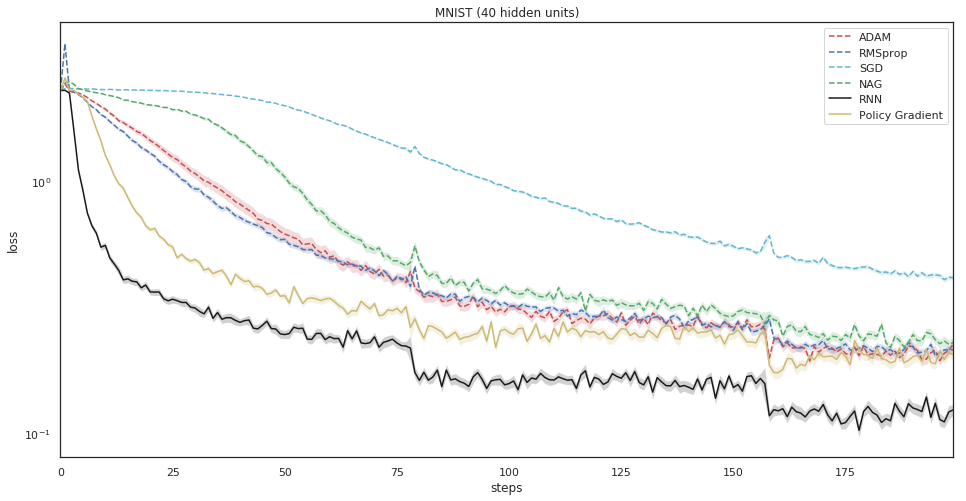

In [35]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

Finally, same as above but with ReLU. As we shall see, the optimizer doesn't generalize very well to a different activation function, and so the other optimizers do much better. My reproduction shows this too although strangely my optimizer seems to do better than the one from the paper.

Original:
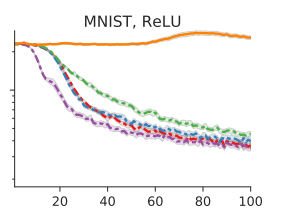

In [36]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTRelu, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTRelu, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


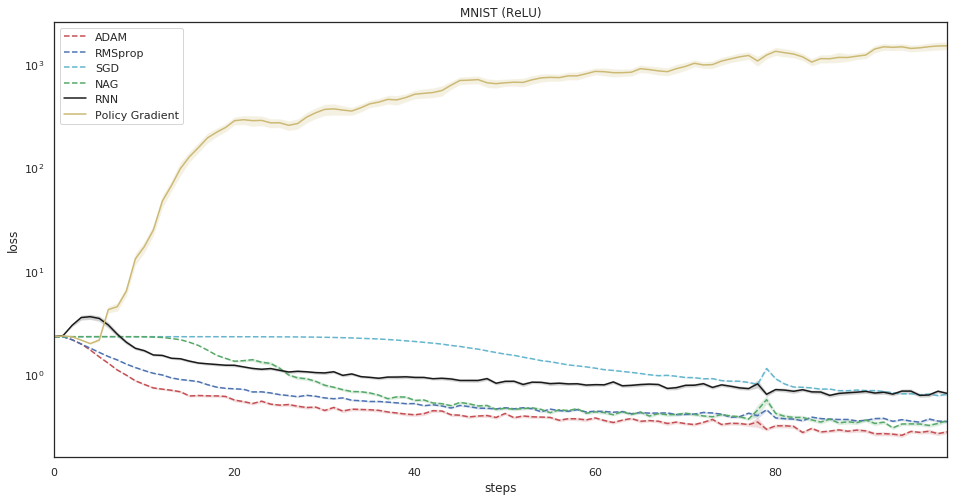

In [37]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


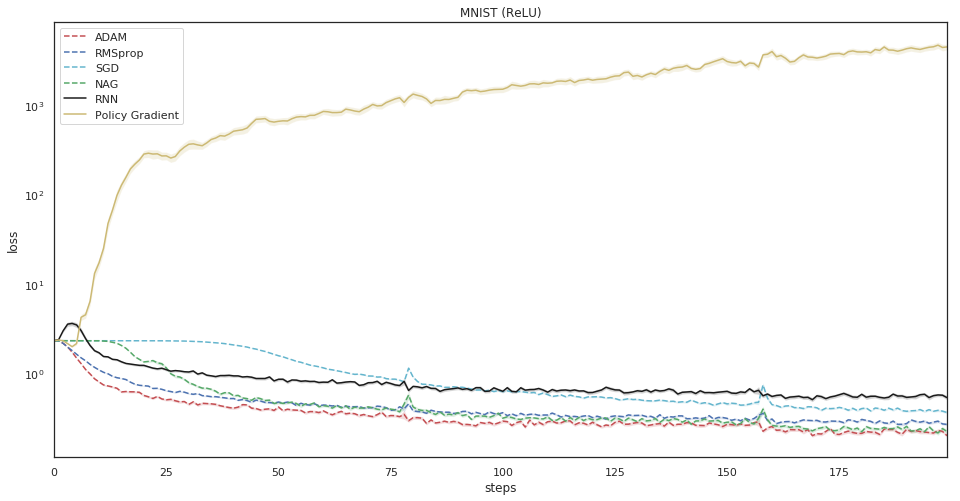

In [38]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

In [28]:
QUAD_LRS = [0.01, 0.003, 0.01, 0.001]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTHuge, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTHuge, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTHuge, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


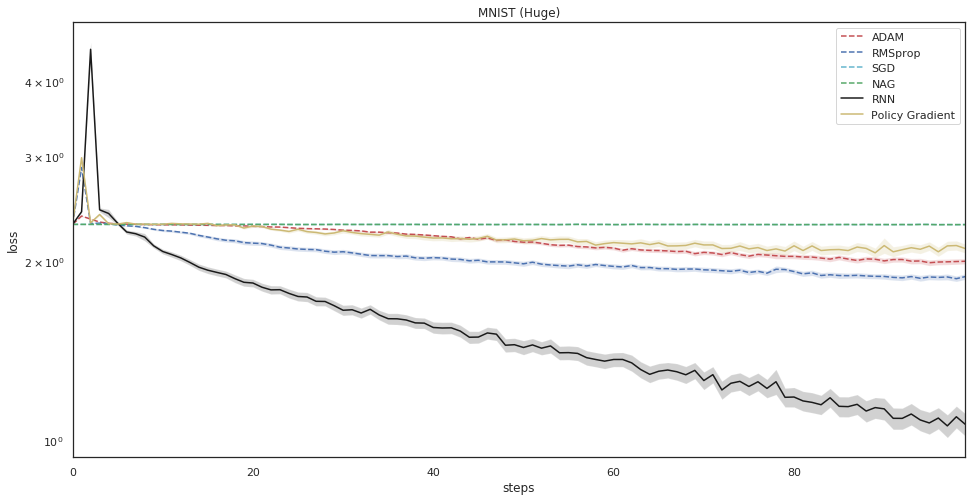

In [29]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (Huge)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


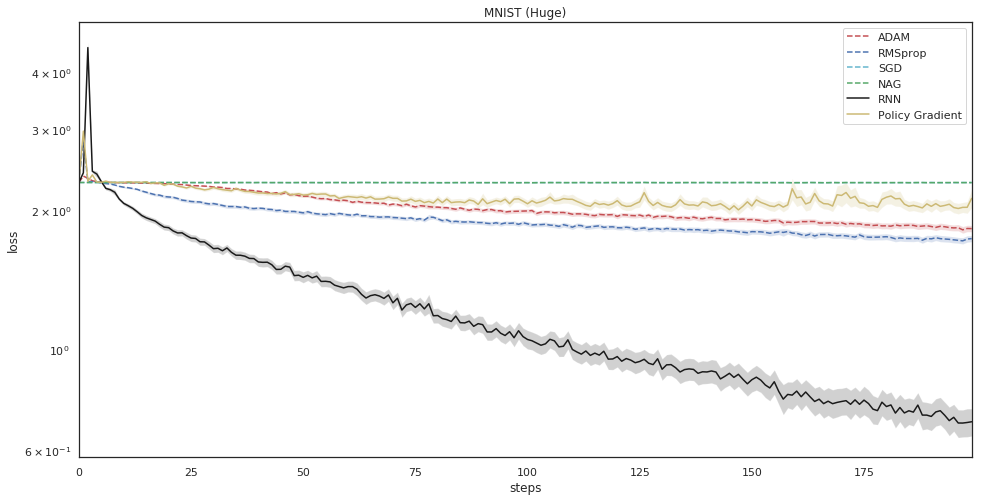

In [30]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (Huge)')
plt.show()

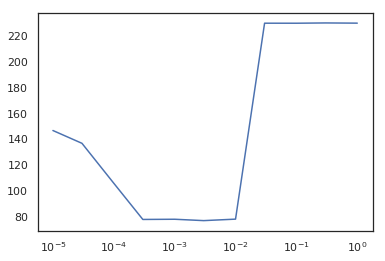

In [39]:
x = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
y = [146.83614, 136.88718, 105.85569, 77.72673, 77.88306, 76.821495, 77.97245, 230.21829, 230.19759, 230.41875, 230.25835]

plt.plot(x, y)
plt.xscale('log')

# MNIST trained with ReLU and Sigmoid

In [31]:
class MNISTNetRandom(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if random.random() > 0.5:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()

In [32]:
# for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
#     print('Trying lr:', lr)
#     print(fit_optimizer(MNISTLoss, MNISTNetRandom, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

In [34]:
loss, mnist_rnn_random_optimizer = fit_optimizer(MNISTLoss, MNISTNetRandom, lr=0.01, out_mul=0.1, preproc=True, n_tests=20, n_epochs=50)
print(loss)

120.33724
100000000000000000 120.33724


110.078445
120.33724 110.078445


102.58772
110.078445 102.58772


100.95937
102.58772 100.95937


100.59711
100.95937 100.59711


103.14577


94.17882
100.59711 94.17882


95.35774


90.30144
94.17882 90.30144


89.58206
90.30144 89.58206


78.62231
89.58206 78.62231


80.818306


101.0049


87.73462


76.711975
78.62231 76.711975


74.668564
76.711975 74.668564


91.50801


91.92833


81.1447


86.26812


85.99507


114.28157


88.85979


115.38729


81.483795


72.96635
74.668564 72.96635


85.32003


79.4551


100.8686


95.952415


74.076904


81.83652


113.948204


99.09122


70.617546
72.96635 70.617546


76.51269


73.55009


73.3226


102.83391


86.71459


68.43001
70.617546 68.43001


66.2252
68.43001 66.2252


71.00077


82.30528


74.67581


67.32206


66.91454


69.253586


91.705734


111.50918
66.2252


In [35]:
# for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
#     print('Trying lr:', lr)
#     print(fit_optimizer_PG(MNISTLoss, MNISTNetRandom, lr=lr, out_mul=0.1, n_tests=5, n_epochs=10, hidden_sz=32, n_layers=2, preproc=True)[0])

In [35]:
loss, mnist_pg_random_optimizer = fit_optimizer_PG(MNISTLoss, MNISTNetRandom, lr=0.003, n_epochs=50, n_tests=20, out_mul=0.1, hidden_sz=32, n_layers=2, preproc=True)
print(loss)

100.797165
1e+17 100.797165


97.673706
100.797165 97.673706


93.81595
97.673706 93.81595


87.56072
93.81595 87.56072


90.65251


83.6589
87.56072 83.6589


90.02548


88.38018


97.98188


91.84191


82.01032
83.6589 82.01032


86.529236


93.17954


84.539116


90.80638


84.98635


79.4869
82.01032 79.4869


80.825714


85.22462


84.09017


82.435875


85.74297


82.87007


83.709175


84.002144


92.51972


93.654236


82.933395


79.34806
79.4869 79.34806


83.18362


88.18467


90.4081


93.185745


91.05179


140.32832


84.342


89.80588


85.01644


89.54488


103.50926


81.52175


83.70491


92.53731


82.597206


87.56173


101.63477


103.22981


88.23972


99.21313


83.94971
79.34806


### Visualization

In [36]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 4))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))


fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 2] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_random_optimizer, 
                                                            None, MNISTLoss, MNISTNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 3] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_random_optimizer, 
                                                            None, MNISTLoss, MNISTNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


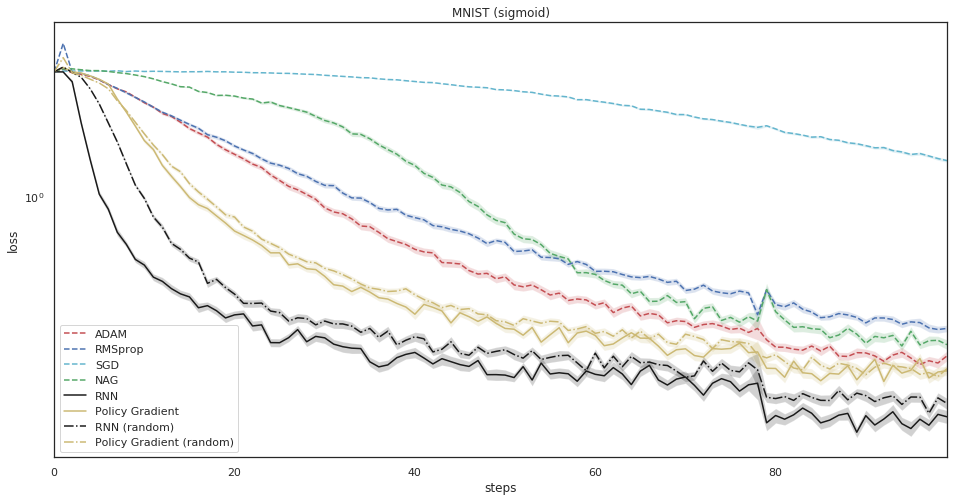

In [37]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient', 'RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y', 'k', 'y'])
ax.lines[-1].set_linestyle('-.')
ax.lines[-2].set_linestyle('-.')
ax.lines[-3].set_linestyle('-')
ax.lines[-4].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (sigmoid)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


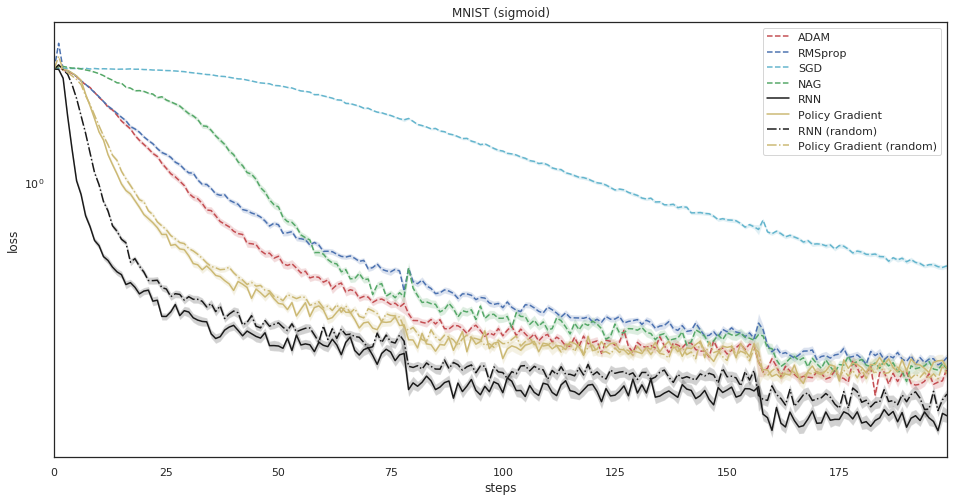

In [38]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient', 'RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y', 'k', 'y'])
ax.lines[-1].set_linestyle('-.')
ax.lines[-2].set_linestyle('-.')
ax.lines[-3].set_linestyle('-')
ax.lines[-4].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (sigmoid)')
plt.show()

In [ ]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 4))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, MNISTLoss, MNISTRelu, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, MNISTLoss, MNISTRelu, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 2] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_random_optimizer, 
                                                            None, MNISTLoss, MNISTRelu, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 3] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_random_optimizer, 
                                                            None, MNISTLoss, MNISTRelu, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

In [ ]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient', 'RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y', 'k', 'y'])
ax.lines[-1].set_linestyle('-.')
ax.lines[-2].set_linestyle('-.')
ax.lines[-3].set_linestyle('-')
ax.lines[-4].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient', 'RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y', 'k', 'y'])
ax.lines[-1].set_linestyle('-.')
ax.lines[-2].set_linestyle('-.')
ax.lines[-3].set_linestyle('-')
ax.lines[-4].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

In [ ]:
fit_data_random_only = np.concatenate((fit_data[:, :, :len(OPT_NAMES)], fit_data[:, :, -2:]), axis=2)

In [ ]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data_random_only[:, :100, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-.')
ax.lines[-2].set_linestyle('-.')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data_random_only[:, :, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-.')
ax.lines[-2].set_linestyle('-.')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

# Transfer to CIFAR

In [37]:
# Download the dataset to it does not give us error messages later
dataset = datasets.CIFAR10(
                './cifar10', train=True, download=True,
                transform=torchvision.transforms.ToTensor()
            )
dataset = datasets.CIFAR10(
                './cifar10', train=False, download=True,
                transform=torchvision.transforms.ToTensor()
           )

Files already downloaded and verified
Files already downloaded and verified


In [38]:
class CifarLoss:
    def __init__(self, phase='train'):
        if phase == 'train' or phase == 'val':
            dataset = datasets.CIFAR10(
                './cifar10', train=True, download=False,
                transform=torchvision.transforms.ToTensor()
            )
        elif phase == 'test':
            dataset = datasets.CIFAR10(
                './cifar10', train=False, download=False,
                transform=torchvision.transforms.ToTensor()
            )
        else:
            raise ValueError("Phase can only take values of 'train', 'val' and 'test'. Given: {}".format(phase))
        
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if phase == 'train':
            indices = indices[:len(indices) // 2]
        elif phase == 'val':
            indices = indices[len(indices) // 2:]
        else:
            pass
    
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
        
        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class CifarNet(nn.Module):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()
        # Sadly this network needs to be implemented without using the convenient pytorch
        # abstractions such as nn.Linear, because afaik there is no way to load parameters
        # in those in a way that preserves gradients.
        if kwargs != {}:
            self.params = kwargs
        else:
            inp_size = 3*32*32
            self.params = {}
            for i in range(n_layers):
                self.params[f'mat_{i}'] = nn.Parameter(torch.randn(inp_size, layer_size) * 0.001) # TODO: use a better initialization
                self.params[f'bias_{i}'] = nn.Parameter(torch.zeros(layer_size))
                inp_size = layer_size

            self.params['final_mat'] = nn.Parameter(torch.randn(inp_size, 10) * 0.001) # TODO:init
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
        
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
                
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 3*32*32)))
        out = w(Variable(out))
        
        cur_layer = 0
        while f'mat_{cur_layer}' in self.params:
            inp = self.activation(torch.matmul(inp, self.params[f'mat_{cur_layer}']) + self.params[f'bias_{cur_layer}'])
            cur_layer += 1
                    
        inp = F.log_softmax(torch.matmul(inp, self.params['final_mat']) + self.params['final_bias'], dim=1)
        l = self.loss(inp, out)
        return l

In [39]:
# for opt, kwargs in NORMAL_OPTS:
#     print(find_best_lr_normal(CifarLoss, CifarNet, opt, **kwargs, n_tests=10))

In [48]:
QUAD_LRS = [0.003, 0.0003, 1.0, 0.3]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(CifarLoss, CifarNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, CifarLoss, CifarNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, CifarLoss, CifarNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


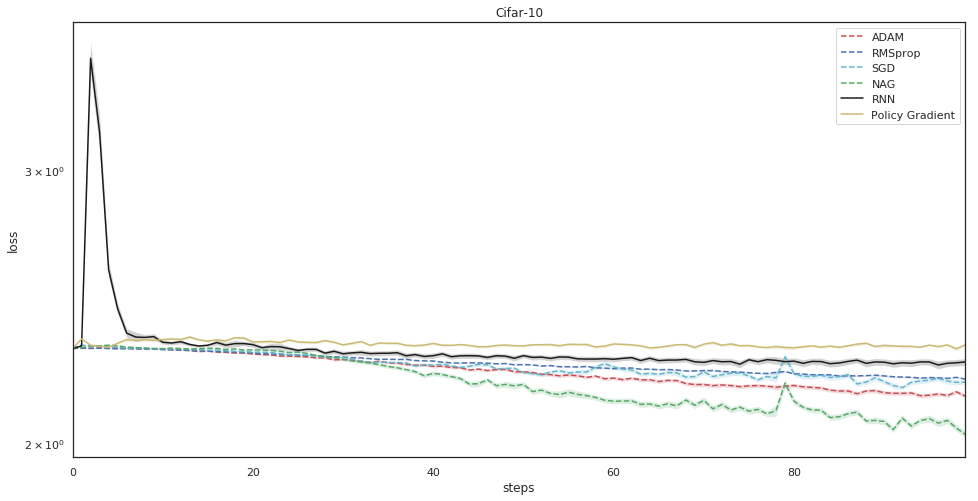

In [49]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


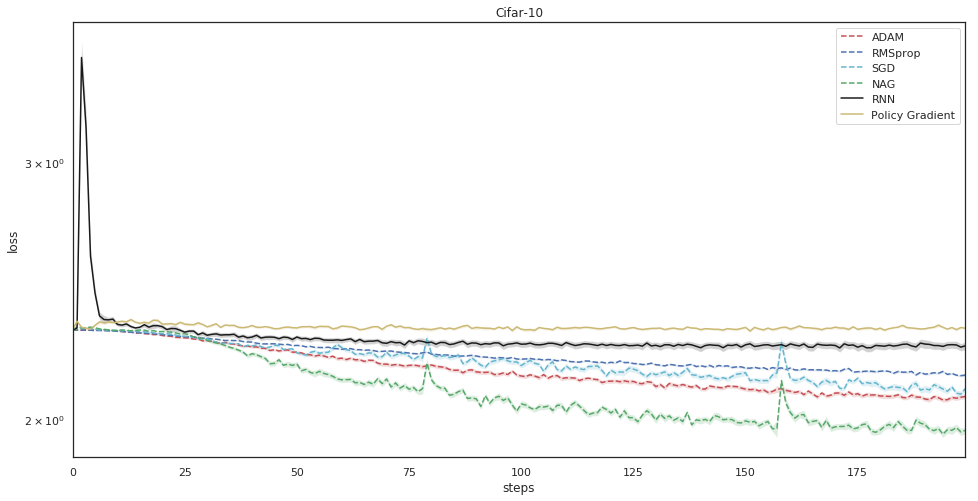

In [50]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10')
plt.show()

### Optimizers trained on random activations - are they more robust to new tasks?

In [40]:
QUAD_LRS = [0.003, 0.0003, 1.0, 0.3]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(CifarLoss, CifarNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_random_optimizer, 
                                                            None, CifarLoss, CifarNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_random_optimizer, 
                                                            None, CifarLoss, CifarNet, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


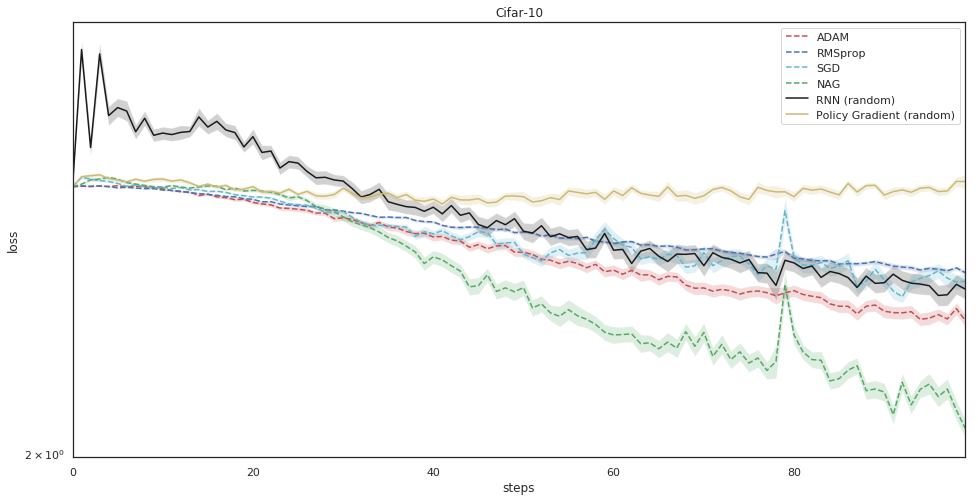

In [41]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


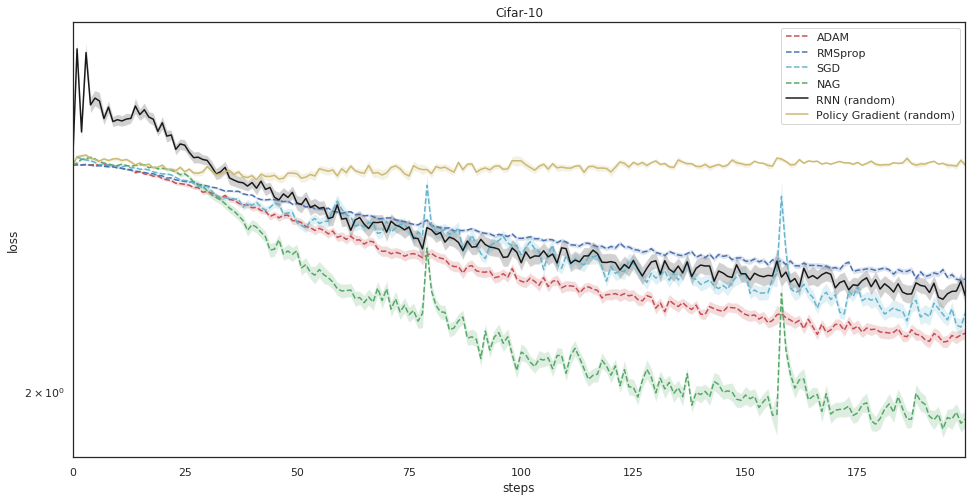

In [42]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10')
plt.show()

## Cifar with 2 layers (is it just the question of too small capacity?)

In [43]:
class CifarNetBig(CifarNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=128, n_layers=2, *args, **kwargs)

In [44]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CifarLoss, CifarNetBig, opt, **kwargs, n_tests=10))

5203.223 1.0
817.39514 0.3
238.02446 0.1
232.9574 0.03
232.09692 0.01
230.3897 0.003
229.7297 0.001
230.219 0.0003
230.31693 0.0001
230.28088 3e-05
230.26619 1e-05

(229.7297, 0.001)


23729.668 1.0
6202.006 0.3
1697.5549 0.1
429.33188 0.03
235.70247 0.01
231.65608 0.003
230.34619 0.001
228.88416 0.0003
230.1978 0.0001
230.30891 3e-05
230.27866 1e-05

(228.88416, 0.0003)


234.06462 1.0
233.22153 0.3
230.98196 0.1
230.48482 0.03
230.3403 0.01
230.28857 0.003
230.26823 0.001
230.2631 0.0003
230.26013 0.0001
230.25957 3e-05
230.25919 1e-05

(230.25919, 1e-05)


237.17969 1.0
230.33316 0.3
232.45389 0.1
231.46188 0.03
230.76395 0.01
230.44502 0.003
230.32852 0.001
230.28276 0.0003
230.2666 0.0001
230.26164 3e-05
230.26062 1e-05

(230.26062, 1e-05)


In [45]:
QUAD_LRS = [0.001, 0.0003, 0.0003, 0.0003]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(CifarLoss, CifarNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_optimizer, 
                                                            None, CifarLoss, CifarNetBig, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_optimizer, 
                                                            None, CifarLoss, CifarNetBig, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


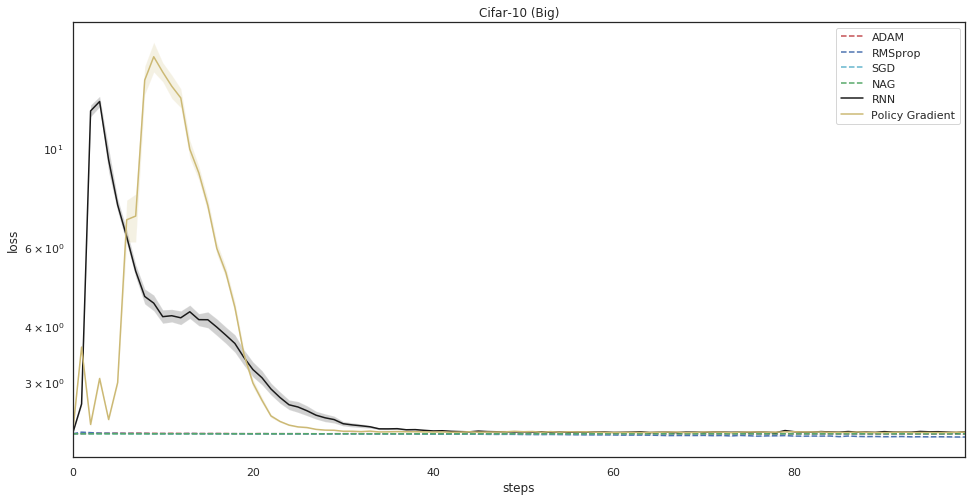

In [46]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10 (Big)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


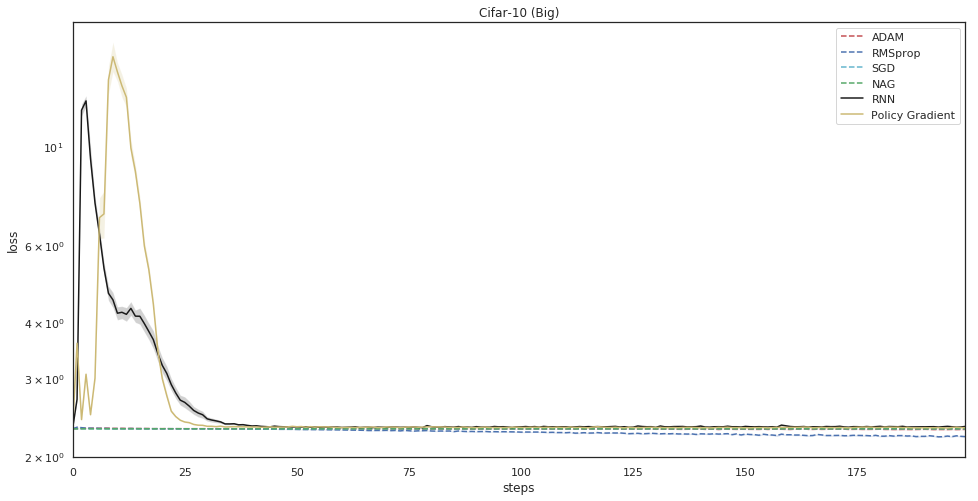

In [47]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10 (Big)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


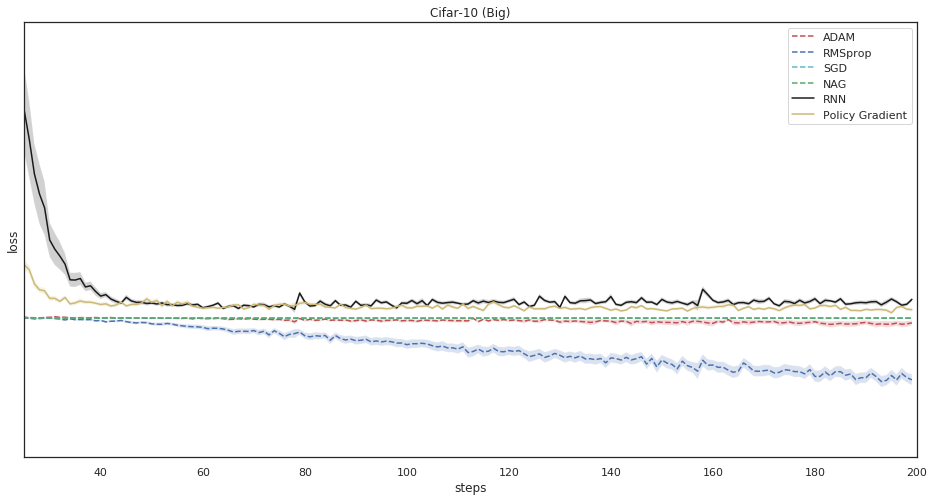

In [55]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN', 'Policy Gradient'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.xlim(25, 200)
plt.ylim(2.1, 2.8)
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10 (Big)')
plt.show()

In [56]:
QUAD_LRS = [0.001, 0.0003, 0.0003, 0.0003]
N_TESTS = 50
NUMBER_OF_EPOCHS = 200

fit_data = np.zeros((N_TESTS, NUMBER_OF_EPOCHS, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(CifarLoss, CifarNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=NUMBER_OF_EPOCHS, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(do_fit, RNN_Optimizer, N_TESTS, mnist_rnn_random_optimizer, 
                                                            None, CifarLoss, CifarNetBig, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))
fit_data[:, :, len(OPT_NAMES) + 1] = np.array(get_fit_dict_test(do_fit_PG, PG_Optimizer, N_TESTS, mnist_pg_random_optimizer, 
                                                            None, CifarLoss, CifarNetBig, 1, NUMBER_OF_EPOCHS, 
                                                            out_mul=0.1, phase='test'))

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


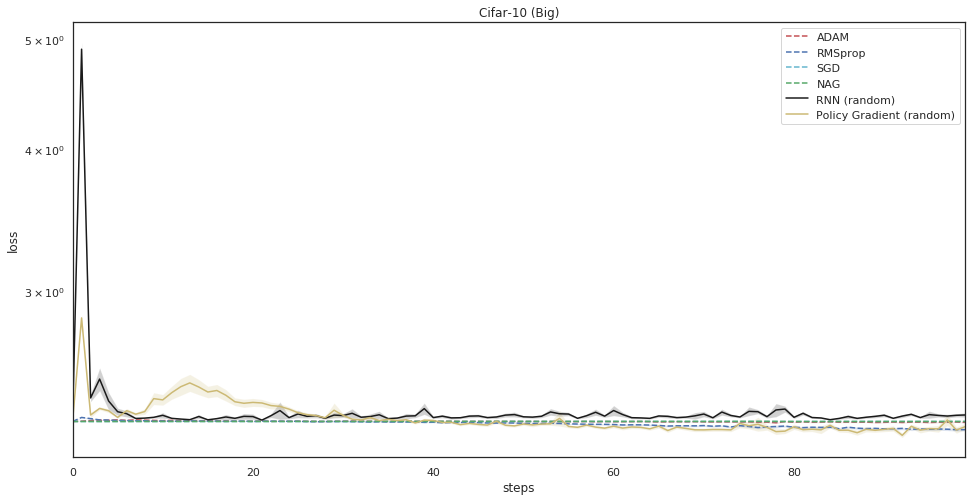

In [57]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :100, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10 (Big)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


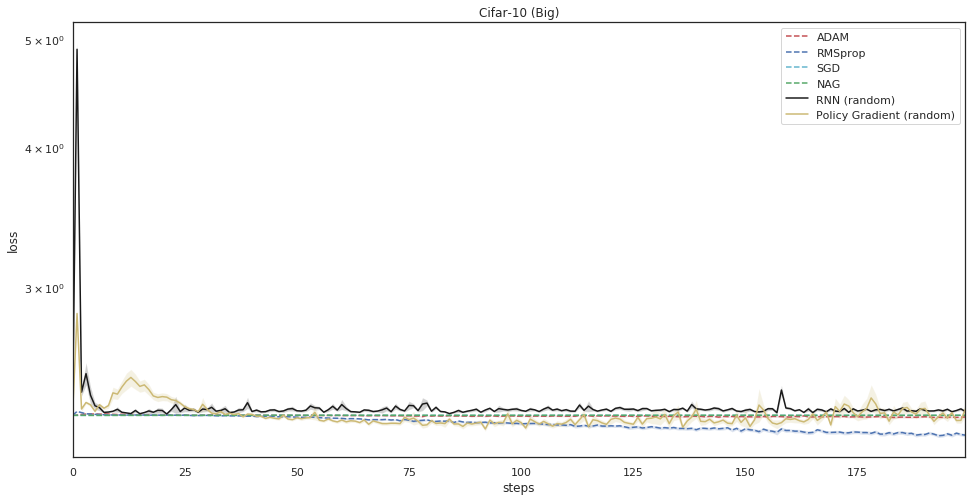

In [58]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10 (Big)')
plt.show()

/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/bfabiandev/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


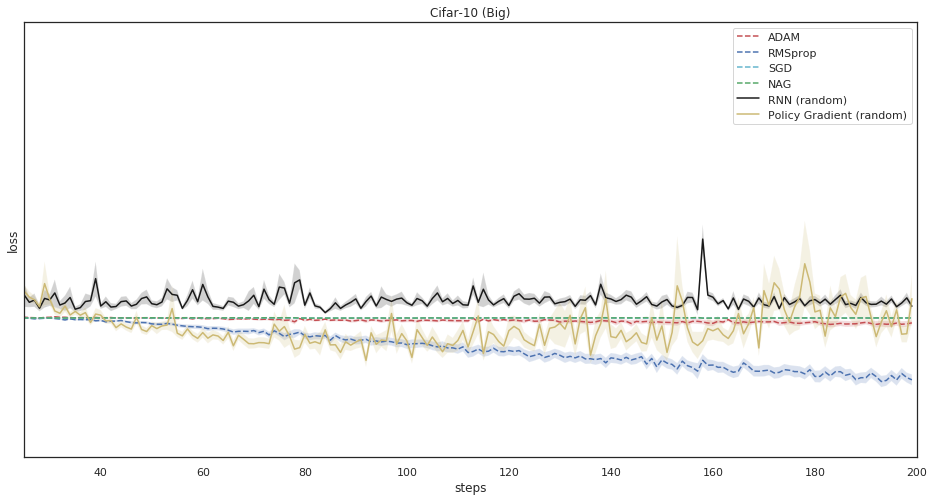

In [59]:
plt.figure(figsize=(16, 8))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['RNN (random)', 'Policy Gradient (random)'], linestyle='--', color=['r', 'b', 'c', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.xlim(25, 200)
plt.ylim(2.1, 2.8)
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Cifar-10 (Big)')
plt.show()